Lab03
=====

###  Context
#### AutoEncoders
   + AutoEncoder
   + Denoise AutoEncoder
   + Variational AutoEncoder

## AutoEncoder
AutoEncoder는 입력과 똑같은 출력을 만들어 내도록 하는 Neural Network의 일종입니다.<br>
데이터를 압축하여 Latent 벡터를 생성하는 Encoder 부분과 Latent 벡터를 가지고 기존의 데이터를 복원하는 Decoder 로 구성되어 있습니다.<br>
여기서 한가지 가정은 AutoEncoder가 생성하는 Latent 벡터는 입력 데이터를 아주 잘 표현하는 벡터이며, 해당 벡터를 복원했을 때 기존의 데이터가 출력 된다는 점 입니다.<br>
이러한 가정으로인해 우리가 AutoEncoder를 차원 축소 기법으로 사용할 수 있습니다. 

![AudoEncoder](./Images/AutoEncoder.png)

### 우리가 만들어볼 AutoEncoder는?
AutoEncoder에서 높은 차원의 입력이 낮은 차원의 각 층을 통과할 때 마다 입력 데이터는 정보를 손실하게 됩니다.<br>
여기에서 낮은 차원으로 내려갈 때 차원이 급격하게 감소하면 정보의 손실은 더욱 심해지게 됩니다.<br>
그래서 이번 실습에서는 입력 데이터의 정보를 덜 손실하면서 잘 복원하는 Stacked AutoEncoder 모델을 만들어 보도록 하겠습니다.<br>



In [1]:
from os.path import join

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats

import tensorflow as tf
import keras
from keras import layers, models, Input, metrics
from keras.utils import to_categorical
from keras.backend import tensorflow_backend as K

import matplotlib.pyplot as plt
import seaborn as sbn

datapath = join('data','MNIST')

# 케라스 백 엔드인 텐서플로우의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# 텐서플로우의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()
# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True 

# 텐서플로우는 세션이라는 실행 단위를 가지고 있는데, 해당 세션에 적용할 옵션을 담고있는 Config객체를 전달합니다.
sess = tf.Session(config=config)
# 설정한 세션을 현재 프로세스에 적용합니다.
set_session(sess)  

Using TensorFlow backend.


## 1. 데이터 살펴보기
이번에 사용할 데이터는 손글씨 데이터로 유명한 MNIST 데이터 입니다.<br>
MNIST(Modified National Institute of Standards and Technology database)는 손으로 쓴 숫자들로 이루어진 대형 데이터셋 입니다.<br>
일반적으로 다양한 영상 처리 시스템을 트레이닝하기 위해 사용됩니다. 또한, 기계 학습 분야의 학습 및 검증에 널리 사용됩니다. <br>
MNIST 데이터셋은 28x28 픽셀의 흑백(Gray scale) 이미지입니다.<br>

![MNIST](./Images/MNIST.png)

data 디렉토리에 준비된 데이터와 라벨을 가져옵니다.<br>

In [2]:
x = np.load(join(datapath, 'MNIST.npy'))
y = np.load(join(datapath, 'Label.npy'))

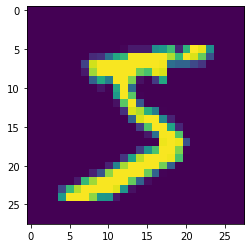

In [3]:
plt.imshow(x[0])

In [4]:
y[0]

5

In [5]:
x[0].shape

(28, 28)

간단한 전처리로 값의 범위를 0~1사이의 값으로 변경시켜줍니다

In [6]:
x = x.reshape((-1, 28, 28, 1))/255

## 3-1. Keras로 Stacked AutoEncoder 만들어보기
이전에는 AutoEncoder를 1차원의 데이터로 바꾼 후, Dense layer로 만들었지만, <br>
이번에는 이미지의 형태를 바꾸지 않고 Convolution layer를 사용해 AutoEncoder를 만들어보겠습니다.<br>
먼저 이론 수업에서 보았던 Stacked AutoEncoder 모델입니다.

![AutoEncoder](./Images/Stacked_AutoEncoder.png)

In [7]:
#parameter
epoch=10
batch_size=1024

In [8]:
# Inputs
input_shape = (28, 28, 1)
input_tensor = Input(input_shape)

# Encoder
# Hidden 1
conv_1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
pooling_1 = layers.MaxPool2D()(conv_1)

# Hidden 2
latent_vector = pooling_1

# Decoder
# Hidden 3
deconv_2 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')(latent_vector)
upsample_3 = layers.UpSampling2D()(deconv_2)

# Outputs
output_tensor = layers.Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')(upsample_3)

ae = models.Model(input_tensor, output_tensor)

ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [10]:
ae.fit(x, x,
       batch_size = batch_size,
       epochs=epoch,
       verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 3s - loss: 0.0641
Epoch 2/10
 - 2s - loss: 0.0041
Epoch 3/10
 - 2s - loss: 0.0025
Epoch 4/10
 - 2s - loss: 0.0019
Epoch 5/10
 - 2s - loss: 0.0016
Epoch 6/10
 - 2s - loss: 0.0014
Epoch 7/10
 - 2s - loss: 0.0013
Epoch 8/10
 - 2s - loss: 0.0012
Epoch 9/10
 - 2s - loss: 0.0011
Epoch 10/10
 - 2s - loss: 0.0011


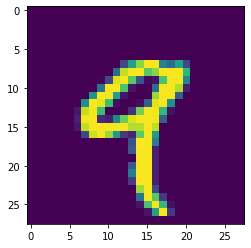

In [11]:
# 원본 데이터 확인
plt.imshow(x[4].reshape(28,28))

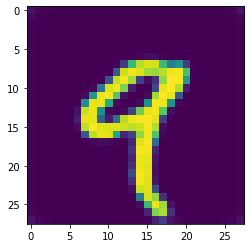

In [12]:
# 복원된 데이터 확인
decoded_img = ae.predict(x[4].reshape(1,28,28,1))
decoded_img = decoded_img.reshape(28,28)

plt.imshow(decoded_img)


## 3-2 Denoise AutoEncoder
Denoise AutoEncoder는 AutoEncoder의 노이즈를 제거하는 특성을 더욱 강화하기 위한 모델입니다.<br>
적당한 예로, 목공예를 배우고자 하는 학생이 품질이 좋지 않은 나무로 연습을 하다보면 조각 한번 한번에 주의를 기울이게되고, 세심하게 작업을 하게됩니다.<br>
그런 학생이 품질이 좋은 나무로 이전과 똑같은 작업을 하게 한다면 이전의 경험을 통해 더욱 좋은 작품을 만들 수 있게 됩니다.<br>
Denoise AutoEncoder의 원리는 이와 비슷합니다. 모델에 넣을 입력에 노이즈를 추가하여 모델이 입력 데이터의 필수적인 부분을 확실하게 추출하도록 유도합니다.<br><br>
논문에서는 기존의 실선에 존재하던 x에 노이즈를 추가해 실선 밖으로 보낸 후 모델을 통해 다시 실선 근처로 가져오는 것으로 설명하고 있습니다.
<img src="./Images/Denoise_AutoEncoder_2.png" style='height:300px' />

### Gaussian Noise
입력에 노이즈를 추가하는 첫 번째 방법으로 Gaussian Noise라 불리는 정규 분포에서 추출한 노이즈를 추가하는 방법입니다.

### Dropout Noise
두 번째 방법으로는 Dropout Noise로 몇몇 픽셀을 0으로 설정하여 제거하는 방법입니다. 


## Denoise AutoEncoder 실습하기
이론 수업에서 보았던 Denoise AutoEncoder 모델을 구현해보겠습니다. Denoise AutoEncoder는 Gaussian noise, Dropout noise 2가지 방식이 있었습니다. <br>
Gaussian noise와, Dropout Layer는 제공해드릴테니 나머지 부분을 직접 작성해보세요!

![Denoise AutoEncoder](./Images/Denoise_AutoEncoder.png)
### Gaussian Denoise AutoEncoder

In [13]:
# noise 추가 함수
def denoise_gaussian(input_tensor):
    noise = K.random_normal(shape=tf.shape(input_tensor),
                              mean=0., stddev=1.0)
    # mean + stddev
    return input_tensor + noise

In [14]:
# Inputs
input_shape = (28, 28, 1)
input_tensor = Input(input_shape)

# 들어온 Input에 정규분포를 가진 노이즈를 추가해줍니다
noise_layer = layers.Lambda(denoise_gaussian)(input_tensor)

# Encoder
# Hidden 1
conv_1 = layers.Conv2D(128, (3,3), padding='same', activation='relu')(noise_layer)
pooling_1 = layers.MaxPool2D()(conv_1)

# letent vector
# Hidden 2
latent_vector = pooling_1

# Decoder
# Hidden 3
deconv_2 = layers.Conv2DTranspose(128, (3,3), padding='same', activation='relu')(latent_vector)
upsample_3 = layers.UpSampling2D()(deconv_2)

# Outputs
output_tensor = layers.Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')(upsample_3)

dae_1 = models.Model(input_tensor, output_tensor)

dae_1.compile(optimizer = 'Adam',
              loss = 'mse',

             )

In [15]:
dae_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       147584    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 1)         1153      
Total para

In [16]:
dae_1.fit(x, x,
         batch_size = batch_size,
         epochs=epoch,
         verbose=2)

Epoch 1/10
 - 5s - loss: 0.1147
Epoch 2/10
 - 3s - loss: 0.0607
Epoch 3/10
 - 3s - loss: 0.0427
Epoch 4/10
 - 3s - loss: 0.0389
Epoch 5/10
 - 3s - loss: 0.0371
Epoch 6/10
 - 3s - loss: 0.0363
Epoch 7/10
 - 3s - loss: 0.0358
Epoch 8/10
 - 3s - loss: 0.0355
Epoch 9/10
 - 3s - loss: 0.0352
Epoch 10/10
 - 3s - loss: 0.0350


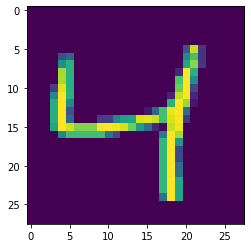

In [17]:
# 원본 데이터 확인
plt.imshow(x[2].reshape(28,28))

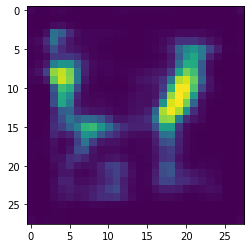

In [18]:
# 복원된 데이터 확인
decoded_img = dae_1.predict(x[2].reshape(1,28,28,1))
decoded_img = decoded_img.reshape(28,28)

plt.imshow(decoded_img)

### Dropout Denoise AutoEncoder

In [19]:
# Inputs
input_shape = (28, 28, 1)
input_tensor = Input(input_shape)

noise_layer = layers.Dropout(0.3)(input_tensor)

# Encoder
# Hidden 1
conv_1 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(noise_layer)
pooling_1 = layers.MaxPool2D()(conv_1)

# letent vector
# Hidden 2
latent_vector = pooling_1

# Decoder
# Hidden 3
deconv_2 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')(latent_vector)
upsample_3 = layers.UpSampling2D()(deconv_2)

# Outputs
output_tensor = layers.Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')(upsample_3)

dae_2 = models.Model(input_tensor, output_tensor)

dae_2.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
dae_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 1)         577       
Total para

In [21]:
dae_2.fit(x, x,
         batch_size = batch_size,
         epochs=epoch,
         verbose=2)

Epoch 1/10
 - 2s - loss: 0.0665
Epoch 2/10
 - 2s - loss: 0.0085
Epoch 3/10
 - 2s - loss: 0.0066
Epoch 4/10
 - 2s - loss: 0.0058
Epoch 5/10
 - 2s - loss: 0.0053
Epoch 6/10
 - 2s - loss: 0.0050
Epoch 7/10
 - 2s - loss: 0.0047
Epoch 8/10
 - 2s - loss: 0.0045
Epoch 9/10
 - 2s - loss: 0.0043
Epoch 10/10
 - 2s - loss: 0.0042


In [22]:
decoded_img = dae_2.predict(x[13].reshape(1,28,28,1))
decoded_img = decoded_img.reshape(28,28)

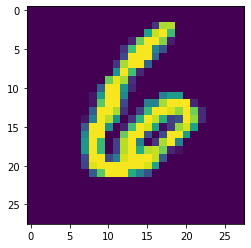

In [23]:
plt.imshow(x[13].reshape(28,28))

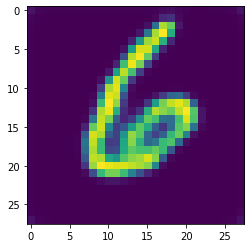

In [24]:
plt.imshow(decoded_img)


## 3-3 Variational AutoEncoder
Variational AutoEncoder(VAE)는 Latent 벡터의 확률 분포까지 생각하는 AutoEncoder의 한 종류입니다. <br>
하지만, 실제 입력 데이터를 완벽하게 표현하는 Latent 벡터의 확률 분포는 찾을 수 없습니다<br>
때문에 실제 확률 분포와 유사하는 분포를 만드는 것을 목적으로 합니다.<br> 
![Variational AutoEncoder](./Images/Variational_AutoEncoder.png)

### 근사하는 확률 분포를 만들기 위한 The reparameterization trick
근사하는 확률 분포를 만들기 위해서는 확률 분포에서 샘플을 추출하는 과정이 필요합니다.<br>
하지만, 샘플링 하는 과정은 미분을 할 수 없기 때문에 약간의 Trick을 사용합니다. <br>
Latent Vector를 샘플링을 해서 decoder의 입력으로 사용하는 것이 아니라, <br>표준 정규 분포에서 샘플링된 데이터에 표준편차를 곱하고 평균을 더해 수학적으로 동일하게 처리합니다.

<img src="./Images/The_reparameterization_trick.png" style='height:300px' />


### Kullback-Leibler divergence
두 확률 분포의 차이를 최소화하기 위해 사용하는 측정 방식으로 두 확률 분포의 거리와 **비슷한 개념**입니다. <br>
항상 양수이며, 같은 확률 분포일 때 0 값을 갖습니다.<br>
여기에서 주의할 점은 비슷한 개념이라고 한 이유는 수식에서 두 확률 분포의 위치를 바꿀 경우 동일한 값이 나오지 않기 때문입니다. <br><br>
$$ L(\theta, \phi, x) = -D_{KL}(q_\phi(z|x)||p_\theta(z))\ +\ E_{q_\phi(z|x)}[logp_\theta(x|z)]$$ 

<img src="./Images/KLD.png" style='height:300px' />

이론적인 내용은 지금까지 배운 이론 중에 가장 복잡하기 때문에 실습 수업에서는 자세히 다루지 않겠습니다. <br>
자세한 내용에 대해 궁금하신분들께서는 레퍼런스로 논문 리뷰 영상 링크 달아드렸으니 확인해보시면 좋겠습니다.

## Variational AutoEncoder 실습하기
이번에는 latent vector가 mean, steddev를 가진 정규분포를 띤다는 Variational AutoEncoder에 대해 실습을 진행해보겠습니다.<br>
이번에는 Dense layer를 사용해 네트워크를 만들어보겠습니다.<br>


28*28 이미지를 784 벡터로 펼칩니다.

In [25]:
original_size = np.size(x[0], axis=0) * np.size(x[0], axis=1)

In [26]:
vx = x.reshape((-1, original_size))


In [27]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 비용 함수를 만들어줍니다.
def my_vae_loss(y_true, y_pred):
    recon = original_size*keras.losses.binary_crossentropy(input_tensor, output_tensor)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    return recon + kl_loss

In [28]:
latent_dim = 128
# Inputs
input_shape = (original_size, )
input_tensor = Input(input_shape)

# Encoder
# Hidden 1
dense_1 = layers.Dense(512, activation='relu')(input_tensor)
dense_2 = layers.Dense(256, activation='relu')(dense_1)

# letent vector
# Hidden 2
latent_vector= layers.Dense(latent_dim, activation='linear')(dense_2)
z_mean= layers.Dense(latent_dim, activation='linear')(dense_2)
z_log_var = layers.Dense(latent_dim, activation='linear')(dense_2)

z = layers.Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

# Decoder
# Hidden 3
dense_5 = layers.Dense(256, activation='relu')(z)
dense_6 = layers.Dense(512, activation='relu')(dense_5)

# Outputs
output_tensor = layers.Dense(original_size, activation='sigmoid')(dense_6)

vae = models.Model(input_tensor, output_tensor)

vae.compile(optimizer = 'Adam', loss=my_vae_loss)

In [29]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

In [30]:
vae.fit(vx, vx,         
        batch_size=batch_size,
        epochs=epoch,
        verbose = 2,
)

Epoch 1/10
 - 1s - loss: 240.7988
Epoch 2/10
 - 1s - loss: 194.9158
Epoch 3/10
 - 1s - loss: 176.5527
Epoch 4/10
 - 1s - loss: 158.4798
Epoch 5/10
 - 1s - loss: 149.5013
Epoch 6/10
 - 1s - loss: 142.8917
Epoch 7/10
 - 1s - loss: 136.9079
Epoch 8/10
 - 1s - loss: 131.5114
Epoch 9/10
 - 1s - loss: 126.9418
Epoch 10/10
 - 1s - loss: 123.0722


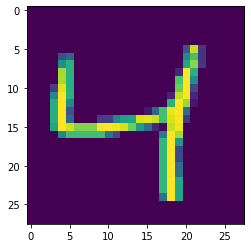

In [31]:
n=2
# 원본 데이터 확인
plt.imshow(x[n].reshape(28,28))

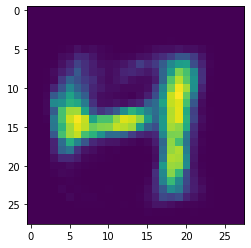

In [32]:
# 데이터를 모델에 넣고 복원시킵니다.
decoded_img = vae.predict(x[n].reshape(1 ,original_size))
decoded_img = decoded_img.reshape(28,28)

# 복원된 데이터 확인
plt.imshow(decoded_img)

### Latent Vector와 z 추출하기

입력한 값을 바탕으로 생성한 latent vector와 latent vector를 기반으로 샘플링한 z의 평균과 분포를 히스토그램으로 살펴보겠습니다<br>
python package seaborn은 matplotlib를 기반으로 작동하는 시각화 패키지입니다<br>
matplotlib보다 간편하게 사용할 수 있다는 장점이 있습니다



MNIST data에 대한 VAE 모델은 이미 학습이 되어있습니다 <br>
또한 케라스는 학습된 그래프의 일부분을 차용하여 새로운 네트워크를 구성 할 수 있습니다<br>
따라서 기존 모델의 입력부분부터 압축된 부분까지를 generate_l이라는 변수로,<br>
입력부분부터 샘플링이 끝난 부분까지를 generate_z라는 변수로, <br>
모델을 만든 후 데이터를 넣어 값을 생성시켜보겠습니다<br><br>
이후 해당 데이터의 첨도,왜도,중위수,평균을 뽑아 얼마나 비슷하게 생성되었는지 살펴보고 히스토그램으로 만들어보겠습니다<br>

또한 이렇게 생성된 값은 Numeric values이기 때문에, 히스토그램을 적용하기에는 부적절합니다.<br>
따라서 Discrete한 value로 바꾸기 위해 소수점 셋째자리에서 반올림처리하겠습니다

Latent Vector의 첨도 = 0.2643
Latent Vector의 왜도 = -0.1612
Latent Vector의 중위수 = 0.0980


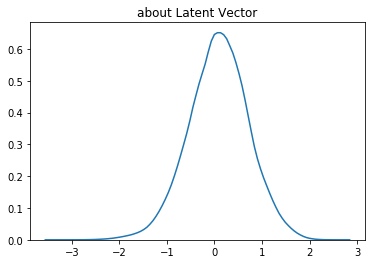

In [33]:
generate_l=models.Model(input_tensor,latent_vector)
latent_values=generate_l.predict(vx).reshape(-1,)


name='Latent Vector'
print('%s의 첨도 = %.4f\n%s의 왜도 = %.4f\n%s의 중위수 = %.4f'%(name,stats.kurtosis(latent_values),
                                                      name,stats.skew(latent_values),
                                                     name,np.median(latent_values)))

latent_values=np.round(latent_values,decimals=3)

plt.figure(0)
plt.title('about Latent Vector')
sbn.kdeplot(latent_values)


Sampled Z Vector의 첨도 = -0.0042
Sampled Z Vector의 왜도 = -0.0023
Sampled Z Vector의 중위수 = -0.0041


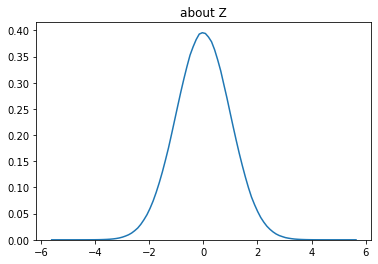

In [34]:
generate_z=models.Model(input_tensor,z)
z_values=generate_z.predict(vx).reshape(-1,)

name='Sampled Z Vector'
print('%s의 첨도 = %.4f\n%s의 왜도 = %.4f\n%s의 중위수 = %.4f'%(name,stats.kurtosis(z_values),
                                                      name,stats.skew(z_values),
                                                     name,np.median(z_values)))
z_values=np.round(z_values,decimals=3)

plt.figure(1)
plt.title('about Z')
sbn.kdeplot(z_values)

## 4. 생성 모델로써의 AutoEncoder
AutoEncoder는 생성 모델의 범주에 들어가므로 실제로 데이터를 생성할 수 있습니다.<br>
이번 실습에서는 wafer 불량 데이터를 Encoding 해서 필수적인 차원만 남기고, <br>
해당 차원에 노이즈를 섞어 비슷한 불량의 특성을 띤 데이터를 만들어보겠습니다.<br>
이어서 VAE로 데이터를 만들어보고 두 방법에 대해 비교해보겠습니다

먼저 데이터를 불러와 살펴보도록 하겠습니다

In [35]:
# 준비된 wafer 데이터를 가져옵니다.
x = np.load('./data/wafer/wafermap_(26,26).npy')

In [36]:
# 데이터 형태를 살펴보겠습니다.
x.shape

(30078, 26, 26, 3)

In [37]:
x[3,17,0]

array([1., 0., 0.])

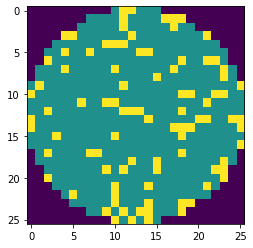

In [38]:
plt.imshow(np.argmax(x[3], axis=2))

In [39]:
# Encoder 부분
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder 부분, Decoder는 레이어에 바로 이전 값을 넣지 않고, Layer 자체로 변수로 저장합니다.
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='relu')

# 레이어로 저장한 Decoder Layer에 Latent vector 부터 순서대로 Decoding하며 연결합니다.
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

# AutoEncoder 모델 정의
ae = models.Model(input_tensor, output_tensor(decode))

# AutoEncoder 모델 생성(컴파일), 최적화기는 Adam, 비용 함수는 mse를 사용합니다.
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [40]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________


In [41]:
# AutoEncoder 모델 학습
ae.fit(x, x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/10
 - 2s - loss: 0.1262
Epoch 2/10
 - 1s - loss: 0.0576
Epoch 3/10
 - 1s - loss: 0.0452
Epoch 4/10
 - 1s - loss: 0.0358
Epoch 5/10
 - 1s - loss: 0.0294
Epoch 6/10
 - 1s - loss: 0.0253
Epoch 7/10
 - 1s - loss: 0.0226
Epoch 8/10
 - 1s - loss: 0.0204
Epoch 9/10
 - 1s - loss: 0.0189
Epoch 10/10
 - 1s - loss: 0.0174


In [42]:
# Encoder 모델 정의 *compile을 통해 모델을 생성하지 않는 이유는 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
encoder = models.Model(input_tensor, latent_vector)

In [43]:
# Decoder 모델
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
# Decoder 모델 정의, *compile을 통해 모델을 생성하지 않는 이유는 이미 ae 모델에서 compile과 학습을 마쳤기 때문입니다.
decoder = models.Model(decoder_input, output_tensor(decode))

In [44]:
# 원본 불량 데이터 인코딩
encoded_x = encoder.predict(x)

In [45]:
# 원본 불량 데이터를 축소시켜 만든 Latent 데이터에 약간의 노이즈를 더해 새로운 데이터를 생성 합니다.
# numpy.random.normal 함수는 loc=평균, scale=표준편차를 가진 정규 분포 노이즈를 생성합니다.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.5, size = (len(encoded_x), 13, 13, 64))

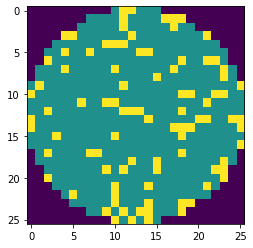

In [46]:
# 원본 불량 데이터 확인
plt.imshow(np.argmax(x[3], axis=2))

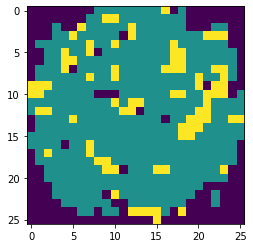

In [47]:
# 노이즈를 섞어 만든 불량 데이터 확인
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

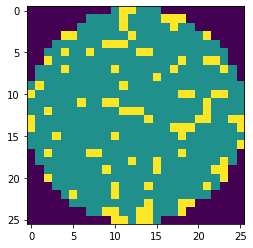

In [48]:
# AutoEncoder가 복원시킨 원본 불량 데이터 확인
gen_x = np.argmax(ae.predict(x), axis=3)
plt.imshow(gen_x[3])

### Reference
- AutoEncoder : https://excelsior-cjh.tistory.com/187
- Denoise AutoEncoder : http://blog.naver.com/PostView.nhn?blogId=laonple&logNo=220891144201&categoryNo=0&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
- Variational AutoEncoder : http://jaejunyoo.blogspot.com/2017/05/auto-encoding-variational-bayes-vae-3.html
- Variational AutoEncoder 논문 리뷰 영상 : https://www.youtube.com/watch?v=KYA-GEhObIs
- Kullback–Leibler divergence : https://en.wikipedia.org/wiki/Kullback–Leibler_divergence